# Predicting Food Delivery Times

In [53]:
!pip install xgboost

In [54]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
import xgboost as xgb
import seaborn as sns
from xgboost import XGBRegressor

In [55]:
%matplotlib inline


In [56]:
df = pd.read_csv('/content/drive/MyDrive/Take Home Test - DS 28 M. Rizky Nugraha A/Food_Delivery_Times.csv')
df.head()

,Order_ID,Distance_km,Weather,Traffic_Level,Time_of_Day,Vehicle_Type,Preparation_Time_min,Courier_Experience_yrs,Delivery_Time_min
0,522,7.93,Windy,Low,Afternoon,Scooter,12,1.0,43
1,738,16.42,Clear,Medium,Evening,Bike,20,2.0,84
2,741,9.52,Foggy,Low,Night,Scooter,28,1.0,59
3,661,7.44,Rainy,Medium,Afternoon,Scooter,5,1.0,37
4,412,19.03,Clear,Low,Morning,Bike,16,5.0,68


In [57]:
df.info(), df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 9 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Order_ID                1000 non-null   int64  
 1   Distance_km             1000 non-null   float64
 2   Weather                 970 non-null    object 
 3   Traffic_Level           970 non-null    object 
 4   Time_of_Day             970 non-null    object 
 5   Vehicle_Type            1000 non-null   object 
 6   Preparation_Time_min    1000 non-null   int64  
 7   Courier_Experience_yrs  970 non-null    float64
 8   Delivery_Time_min       1000 non-null   int64  
dtypes: float64(2), int64(3), object(4)
memory usage: 70.4+ KB


(None,
           Order_ID  Distance_km  Preparation_Time_min  Courier_Experience_yrs  \
 count  1000.000000  1000.000000           1000.000000              970.000000   
 mean    500.500000    10.059970             16.982000                4.579381   
 std     288.819436     5.696656              7.204553                2.914394   
 min       1.000000     0.590000              5.000000                0.000000   
 25%     250.750000     5.105000             11.000000                2.000000   
 50%     500.500000    10.190000             17.000000                5.000000   
 75%     750.250000    15.017500             23.000000                7.000000   
 max    1000.000000    19.990000             29.000000                9.000000   
 
        Delivery_Time_min  
 count        1000.000000  
 mean           56.732000  
 std            22.070915  
 min             8.000000  
 25%            41.000000  
 50%            55.500000  
 75%            71.000000  
 max           153.000000  )

# Data Preprossesing

In [58]:
# Handle missing values for numerical columns
numerical_columns = ['Distance_km', 'Preparation_Time_min', 'Courier_Experience_yrs']
df[numerical_columns] = df[numerical_columns].fillna(df[numerical_columns].median())

In [59]:
# Handle missing values for categorical columns
categorical_columns = ['Weather', 'Traffic_Level', 'Time_of_Day', 'Vehicle_Type']
df[categorical_columns] = df[categorical_columns].fillna(df[categorical_columns].mode().iloc[0])

In [60]:
# Handle missing values
# Identify columns with missing values
missing_values = df.isnull().sum()
print(missing_values)

Order_ID                  0
Distance_km               0
Weather                   0
Traffic_Level             0
Time_of_Day               0
Vehicle_Type              0
Preparation_Time_min      0
Courier_Experience_yrs    0
Delivery_Time_min         0
dtype: int64


In [61]:
df.info(), df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 9 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Order_ID                1000 non-null   int64  
 1   Distance_km             1000 non-null   float64
 2   Weather                 1000 non-null   object 
 3   Traffic_Level           1000 non-null   object 
 4   Time_of_Day             1000 non-null   object 
 5   Vehicle_Type            1000 non-null   object 
 6   Preparation_Time_min    1000 non-null   int64  
 7   Courier_Experience_yrs  1000 non-null   float64
 8   Delivery_Time_min       1000 non-null   int64  
dtypes: float64(2), int64(3), object(4)
memory usage: 70.4+ KB


(None,
           Order_ID  Distance_km  Preparation_Time_min  Courier_Experience_yrs  \
 count  1000.000000  1000.000000           1000.000000             1000.000000   
 mean    500.500000    10.059970             16.982000                4.592000   
 std     288.819436     5.696656              7.204553                2.871198   
 min       1.000000     0.590000              5.000000                0.000000   
 25%     250.750000     5.105000             11.000000                2.000000   
 50%     500.500000    10.190000             17.000000                5.000000   
 75%     750.250000    15.017500             23.000000                7.000000   
 max    1000.000000    19.990000             29.000000                9.000000   
 
        Delivery_Time_min  
 count        1000.000000  
 mean           56.732000  
 std            22.070915  
 min             8.000000  
 25%            41.000000  
 50%            55.500000  
 75%            71.000000  
 max           153.000000  )

In [62]:
# Removing Order_ID in the dataset since it is not needed

df = df[["Distance_km", "Weather", "Traffic_Level", "Time_of_Day", "Vehicle_Type", "Preparation_Time_min", "Courier_Experience_yrs", "Delivery_Time_min"]].dropna()

In [63]:
# Separate features and target
X = df.drop(columns=['Distance_km', 'Weather', 'Traffic_Level', 'Time_of_Day', 'Vehicle_Type', 'Preparation_Time_min', 'Courier_Experience_yrs' ])
y = df['Delivery_Time_min']

In [64]:
# Setting the values of Weather into integers
# Clear = 0
# Windy = 1
# Foggy = 2
# Rainy = 3
# Snowy = 4

df["Weather"] = df["Weather"].map({"Clear": 0, "Windy": 1, "Foggy": 2, "Rainy": 3, "Snowy": 4})

In [65]:
# Setting the values of Time of Day into integers
# Morning = 0
# Afternoon = 1
# Evening = 2
# Night = 3

df["Time_of_Day"] = df["Time_of_Day"].map({"Morning": 0, "Afternoon": 1, "Evening": 2, "Night": 3})

In [66]:
# Setting the values of Traffic Level into integers
# Low = 0
# Medium = 1
# High = 2

df["Traffic_Level"] = df["Traffic_Level"].map({"Low": 0, "Medium": 1, "High": 2})

In [67]:
# Setting the values of Vehicle Type into integers
# Scooter = 0
# Bike = 1
# Car = 2

df["Vehicle_Type"] = df["Vehicle_Type"].map({"Scooter": 0, "Bike": 1, "Car": 2})

In [68]:
# Finalized Dataset

df

,Distance_km,Weather,Traffic_Level,Time_of_Day,Vehicle_Type,Preparation_Time_min,Courier_Experience_yrs,Delivery_Time_min
0,7.93,1,0,1,0,12,1.0,43
1,16.42,0,1,2,1,20,2.0,84
2,9.52,2,0,3,0,28,1.0,59
3,7.44,3,1,1,0,5,1.0,37
4,19.03,0,0,0,1,16,5.0,68
...,...,...,...,...,...,...,...,...
995,8.50,0,2,2,2,13,3.0,54
996,16.28,3,0,0,0,8,9.0,71
997,15.62,4,2,2,0,26,2.0,81
998,14.17,0,0,1,1,8,0.0,55


In [69]:
df. describe()

,Distance_km,Weather,Traffic_Level,Time_of_Day,Vehicle_Type,Preparation_Time_min,Courier_Experience_yrs,Delivery_Time_min
count,1000.000000,1000.00000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,10.059970,1.30200,0.814000,1.125000,0.893000,16.982000,4.592000,56.732000
std,5.696656,1.48425,0.738884,0.977922,0.697164,7.204553,2.871198,22.070915
min,0.590000,0.00000,0.000000,0.000000,0.000000,5.000000,0.000000,8.000000
25%,5.105000,0.00000,0.000000,0.000000,0.000000,11.000000,2.000000,41.000000
50%,10.190000,0.50000,1.000000,1.000000,1.000000,17.000000,5.000000,55.500000
75%,15.017500,3.00000,1.000000,2.000000,1.000000,23.000000,7.000000,71.000000
max,19.990000,4.00000,2.000000,3.000000,2.000000,29.000000,9.000000,153.000000


In [70]:
# Display the shape of the dataset

df.shape

(1000, 8)

In [71]:
# Checking for any missing values

print(df.isnull().sum())

Distance_km               0
Weather                   0
Traffic_Level             0
Time_of_Day               0
Vehicle_Type              0
Preparation_Time_min      0
Courier_Experience_yrs    0
Delivery_Time_min         0
dtype: int64


In [72]:
# Delivery_Time_Min will be the target value and splitting the data

X = df[["Distance_km", "Weather", "Traffic_Level", "Time_of_Day", "Vehicle_Type", "Preparation_Time_min", "Courier_Experience_yrs"]]
y = df["Delivery_Time_min"]

In [73]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Exploratory Data Analysis (EDA)

In [74]:
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
import seaborn as sns

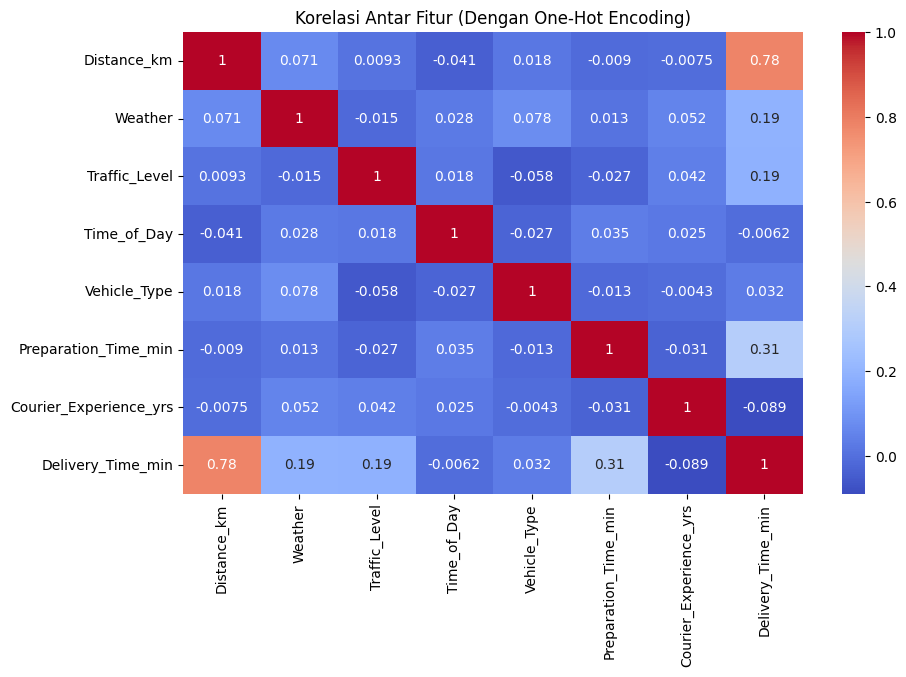

In [75]:
# Mengonversi kolom kategorikal ke dalam bentuk numerik (One-Hot Encoding)
df_encoded = pd.get_dummies(df, drop_first=True)

# Visualisasi korelasi antar fitur numerik dengan target Delivery_Time_min
plt.figure(figsize=(10, 6))
sns.heatmap(df_encoded.corr(), annot=True, cmap='coolwarm')
plt.title("Korelasi Antar Fitur (Dengan One-Hot Encoding)")
plt.show()

1. Jarak Pengiriman (Distance_km) dan Waktu Pengiriman (Delivery_Time_min):
Korelasi 0.78 antara Distance_km dan Delivery_Time_min menunjukkan hubungan yang sangat kuat antara jarak pengiriman dan waktu pengiriman. Ini berarti semakin jauh jarak pengiriman, semakin lama waktu yang dibutuhkan untuk pengantaran. Ini adalah insight yang sangat penting untuk memperkirakan waktu pengantaran berdasarkan jarak.

2. Cuaca (Weather):
Weather memiliki korelasi yang sangat rendah dengan hampir semua fitur lainnya, yang menunjukkan bahwa kondisi cuaca tidak terlalu berpengaruh langsung terhadap variabel lain seperti waktu pengiriman atau jarak. Namun, sedikit pengaruhnya terlihat pada Time_of_Day dan Vehicle_Type.

3. Tingkat Lalu Lintas (Traffic_Level):
Traffic_Level juga menunjukkan korelasi yang rendah dengan variabel lain, namun memiliki korelasi moderat dengan Delivery_Time_min (0.19). Ini menunjukkan bahwa kondisi lalu lintas sedikit mempengaruhi waktu pengiriman, meskipun tidak sekuat faktor jarak.

4. Waktu dalam Sehari (Time_of_Day):
Time_of_Day memiliki korelasi yang sangat lemah dengan Delivery_Time_min, menunjukkan bahwa waktu pengantaran (pagi, siang, malam) tidak mempengaruhi waktu pengiriman secara signifikan.

5. Jenis Kendaraan (Vehicle_Type):
Vehicle_Type menunjukkan korelasi sangat rendah dengan Delivery_Time_min dan Traffic_Level, namun sedikit lebih tinggi terhadap Weather dan Time_of_Day. Hal ini menunjukkan bahwa jenis kendaraan mungkin lebih terkait dengan faktor-faktor seperti kondisi cuaca atau waktu dalam sehari, daripada waktu pengiriman atau lalu lintas.

6. Waktu Persiapan (Preparation_Time_min):
Preparation_Time_min memiliki korelasi moderat dengan Delivery_Time_min (0.31), yang menunjukkan bahwa waktu persiapan mempengaruhi total waktu pengiriman. Semakin lama waktu persiapan, semakin lama waktu yang dibutuhkan untuk pengiriman.

7. Pengalaman Kurir (Courier_Experience_yrs):
Courier_Experience_yrs memiliki korelasi yang sangat rendah dengan fitur lainnya, menunjukkan bahwa pengalaman kurir tidak memiliki pengaruh besar terhadap waktu pengiriman dalam dataset ini.

#Kesimpulan:
Heatmap ini memberikan gambaran yang jelas bahwa jarak pengiriman adalah faktor utama dalam menentukan waktu pengiriman, dengan waktu persiapan dan lalu lintas juga berkontribusi secara signifikan. Perusahaan dapat fokus pada optimasi rute dan waktu persiapan untuk meningkatkan kecepatan pengiriman dan memanfaatkan informasi lalu lintas dan cuaca untuk mengurangi ketidakpastian dalam estimasi waktu pengiriman.

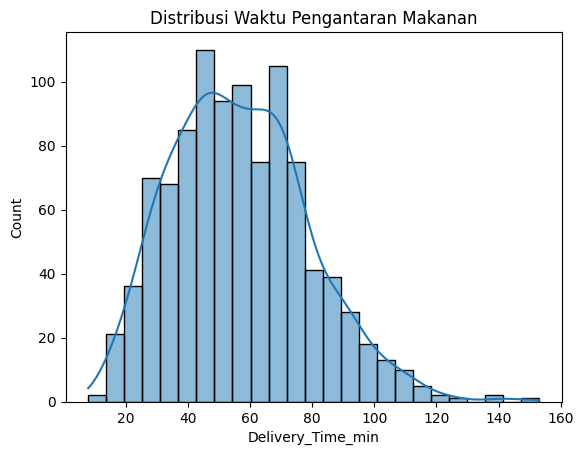

In [76]:
# Visualisasi distribusi Delivery_Time_min
sns.histplot(df['Delivery_Time_min'], kde=True)
plt.title("Distribusi Waktu Pengantaran Makanan")
plt.show()

1. Pola Distribusi:
Distribusi waktu pengantaran makanan cenderung normal atau hampir simetris dengan puncak pada rentang 40-60 menit. Ini menunjukkan bahwa sebagian besar pengiriman selesai dalam rentang waktu tersebut.

2. Jumlah Pengiriman pada Waktu Rata-Rata:
Mayoritas pengiriman terjadi dalam rentang waktu sekitar 50-70 menit, dengan beberapa fluktuasi, yang mengindikasikan bahwa waktu pengiriman rata-rata biasanya berada di sekitar angka tersebut.

3. Outliers:
Ada outliers atau pengiriman yang lebih lama, terutama di sisi kanan histogram, di atas 100 menit. Ini menunjukkan bahwa ada beberapa pengiriman yang memerlukan waktu lebih lama dari biasanya. Hal ini bisa disebabkan oleh berbagai faktor, seperti kemacetan lalu lintas, kondisi cuaca buruk, atau masalah operasional.

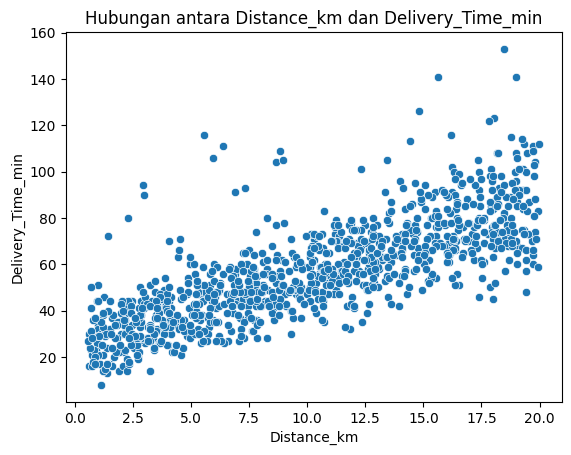

In [77]:
# Scatter plot untuk melihat hubungan antar fitur dengan Delivery_Time_min
sns.scatterplot(x=df['Distance_km'], y=df['Delivery_Time_min'])
plt.title("Hubungan antara Distance_km dan Delivery_Time_min")
plt.show()

1. Hubungan Positif yang Kuat:
Terdapat hubungan positif yang jelas antara jarak pengiriman dan waktu pengiriman. Ketika jarak pengiriman meningkat, waktu pengiriman juga cenderung meningkat. Ini menunjukkan bahwa jarak pengiriman adalah faktor utama yang mempengaruhi durasi pengantaran.

2. Konsistensi Tren:
Meskipun ada beberapa titik yang lebih tersebar, tren umumnya menunjukkan bahwa semakin jauh jarak pengiriman, semakin lama waktu yang dibutuhkan. Hal ini sangat sesuai dengan analisis sebelumnya bahwa jarak pengiriman berkontribusi besar terhadap waktu pengiriman.

3. Fluktuasi di Jarak Lebih Pendek:
Pada jarak pendek (kurang dari 5 km), terdapat lebih banyak fluktuasi waktu pengiriman, yang bisa disebabkan oleh faktor lain seperti kondisi lalu lintas, waktu dalam sehari, atau masalah operasional.

4. Konsistensi di Jarak Jauh:
Pada jarak yang lebih panjang (lebih dari 10 km), waktu pengiriman tampak lebih konsisten, meskipun ada beberapa titik yang sedikit lebih tinggi. Ini menunjukkan bahwa pengantaran untuk jarak jauh relatif lebih terprediksi, meskipun kondisi eksternal masih dapat mempengaruhinya.

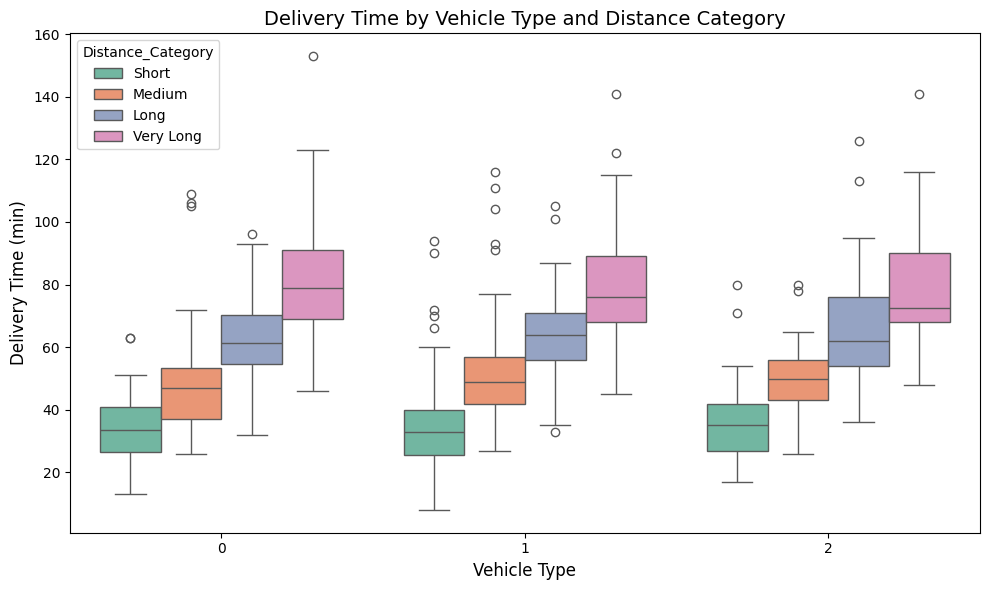

In [78]:
# Convert Distance_km into categorical bins to make visualization clearer
df['Distance_Category'] = pd.qcut(df['Distance_km'], q=4, labels=['Short', 'Medium', 'Long', 'Very Long'])

# Visualize Delivery Time by Vehicle Type and Distance Category using a boxplot
plt.figure(figsize=(10, 6))

sns.boxplot(x='Vehicle_Type', y='Delivery_Time_min', hue='Distance_Category', data=df, palette='Set2')

# Titles and labels
plt.title('Delivery Time by Vehicle Type and Distance Category', fontsize=14)
plt.xlabel('Vehicle Type', fontsize=12)
plt.ylabel('Delivery Time (min)', fontsize=12)

# Show plot
plt.tight_layout()
plt.show()

# Vehicle_Type :
- Scooter = 0
- Bike = 1
- Car = 2


# Distance Category
- Short: 0.59 km – 5.105 km
- Medium: 5.105 km – 10.19 km
- Long: 10.19 km – 15.018 km
- Very Long: 15.018 km – 19.99 km

# Insight Boxplot :

1. Pengaruh Tipe Kendaraan terhadap Waktu Pengiriman:
- Scooter memiliki waktu pengiriman paling cepat dibandingkan dengan Bike dan Car, terutama pada jarak pendek dan menengah.
- Car cenderung memiliki waktu pengiriman lebih lama, terutama untuk jarak yang lebih jauh.

2. Pengaruh Jarak terhadap Waktu Pengiriman:
- Semakin jauh jaraknya (Very Long), semakin lama waktu pengiriman, terlepas dari jenis kendaraan yang digunakan.
- Untuk jarak pendek (Short), semua kendaraan menunjukkan waktu pengiriman yang lebih rendah, tetapi Scooter tetap menjadi yang paling efisien.

# Latih dan Evaluasi Model Machine Learning

In [79]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import xgboost as xgb

In [80]:
# Membuat model Linear Regression dan XGBoost
models = {
    'Linear Regression': LinearRegression(),
    'XGBoost': xgb.XGBRegressor(objective='reg:squarederror', random_state=42)
}

# Dictionary untuk menyimpan performa model
model_performance = {}

In [81]:
# Latih dan evaluasi setiap model
for model_name, model in models.items():
    # Melatih model dengan data training
    model.fit(X_train, y_train)

    # Prediksi dengan data test
    y_pred = model.predict(X_test)

    # Evaluasi dengan MSE dan R-squared
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    # Menyimpan hasil evaluasi
    model_performance[model_name] = {'MSE': mse, 'R2': r2}

In [82]:
# Menampilkan hasil performa tiap model
print("Model Performance:")
for model_name, performance in model_performance.items():
    print(f"{model_name} - MSE: {performance['MSE']:.4f}, R2: {performance['R2']:.4f}")

Model Performance:
Linear Regression - MSE: 79.9739, R2: 0.8216
XGBoost - MSE: 110.1461, R2: 0.7543


In [83]:
# Evaluasi Model: Visualisasi prediksi vs nilai aktual
def plot_predictions(model_name, y_test, y_pred):
    plt.figure(figsize=(8, 6))
    plt.scatter(y_test, y_pred, alpha=0.7)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--r', label='Ideal Prediction')
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.title(f'{model_name} - Prediksi vs Nilai Aktual')
    plt.legend()
    plt.show()

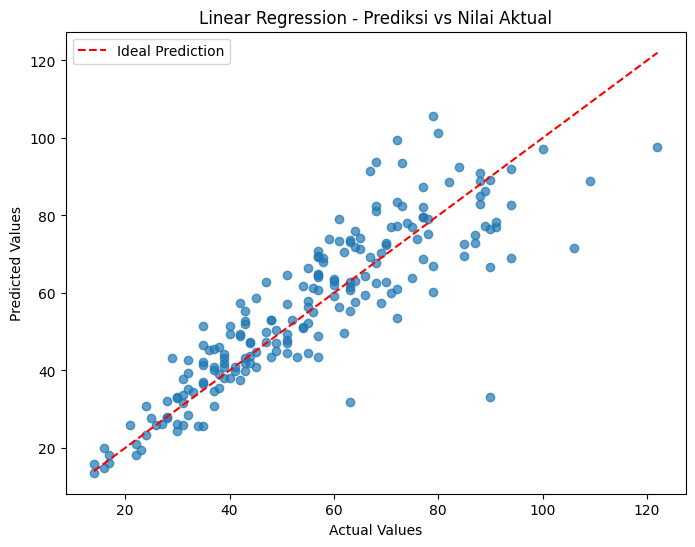

In [84]:
plot_predictions("Linear Regression", y_test, y_pred)

- Hubungan Positif yang Kuat:
Terdapat hubungan positif yang kuat antara nilai aktual dan nilai prediksi, yang terlihat pada sebaran titik yang hampir mengikuti garis diagonal. Ini menunjukkan bahwa model Linear Regression cukup efektif dalam memprediksi nilai waktu pengantaran.

- Ideal Prediction (Garis Putus-Putus):
Garis putus-putus Ideal Prediction menggambarkan garis sempurna di mana nilai prediksi dan aktual akan selalu sama. Titik data yang berada dekat dengan garis ini menunjukkan prediksi yang sangat baik.
Mayoritas titik data berada cukup dekat dengan garis tersebut, menandakan bahwa model ini dapat memprediksi waktu pengantaran dengan akurasi yang cukup tinggi.

- Beberapa Titik di Luar Garis Ideal:
Meskipun sebagian besar titik mendekati garis ideal, terdapat beberapa titik yang agak jauh dari garis tersebut, menunjukkan bahwa ada beberapa kesalahan prediksi pada model ini. Ini bisa disebabkan oleh faktor lain yang tidak tercakup dalam model.

In [85]:
# Visualisasi residual (perbedaan antara nilai aktual dan prediksi)
def plot_residuals(model_name, y_test, y_pred):
    residuals = y_test - y_pred
    plt.figure(figsize=(8, 6))
    plt.scatter(y_test, residuals, alpha=0.7)
    plt.axhline(y=0, color='r', linestyle='--')
    plt.xlabel('Actual Values')
    plt.ylabel('Residuals')
    plt.title(f'{model_name} - Residual Plot')
    plt.show()

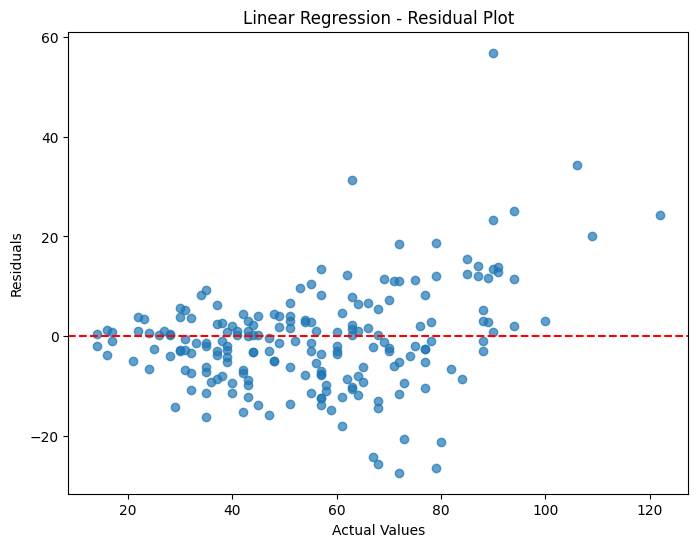

In [86]:
plot_residuals("Linear Regression", y_test, y_pred)

1. Distribusi Residuals:
Residuals cenderung tersebar di sekitar garis horizontal 0, yang menunjukkan bahwa model tidak memiliki bias sistematik (prediksi terlalu tinggi atau terlalu rendah). Ini adalah tanda bahwa model Linear Regression bekerja dengan baik dalam hal tidak menghasilkan kesalahan yang terstruktur.

2. Pola Acak:
Titik-titik residual tersebar secara acak, tanpa pola yang jelas, yang mengindikasikan bahwa model sudah mengakomodasi pola data dengan baik. Ini adalah tanda bahwa model Linear Regression tidak memiliki kesalahan sistematik yang bisa diprediksi berdasarkan nilai aktual.

3. Beberapa Titik Ekstrem (Outliers):
Ada beberapa titik yang jauh dari garis horizontal (positif dan negatif), menunjukkan adanya outliers. Titik-titik ini mungkin merupakan kasus khusus yang tidak dapat dijelaskan oleh model dan mempengaruhi kualitas prediksi. Outliers ini bisa disebabkan oleh faktor eksternal atau kejadian yang jarang terjadi yang tidak terduga oleh model.

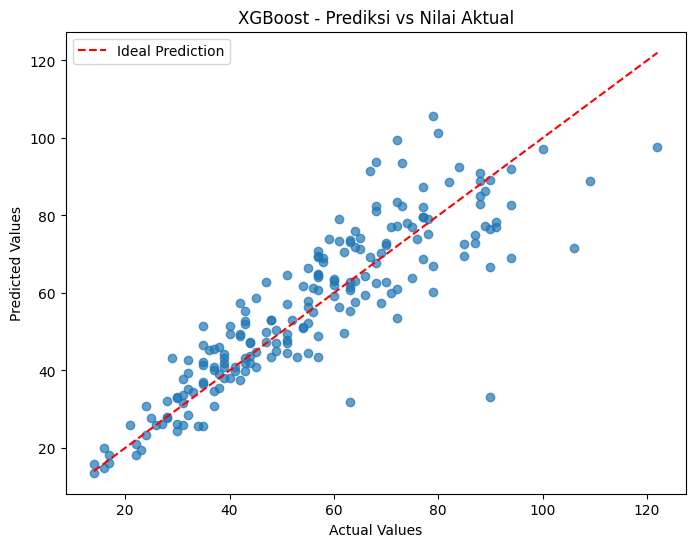

In [87]:
plot_predictions("XGBoost", y_test, y_pred)

Plot Prediksi vs Nilai Aktual (XGBoost):

- XGBoost menunjukkan hubungan positif yang kuat antara nilai aktual dan nilai prediksi. Titik-titik hampir mengikuti garis Ideal Prediction (garis putus-putus), yang menunjukkan bahwa model XGBoost menghasilkan prediksi yang akurat dan mendekati nilai sebenarnya.
- Garis diagonal menunjukkan bahwa model sangat baik dalam memperkirakan waktu pengantaran, dengan sebagian besar titik data mendekati garis tersebut. Meskipun demikian, masih ada beberapa titik yang sedikit lebih jauh dari garis tersebut, yang menunjukkan adanya kesalahan prediksi atau outliers.

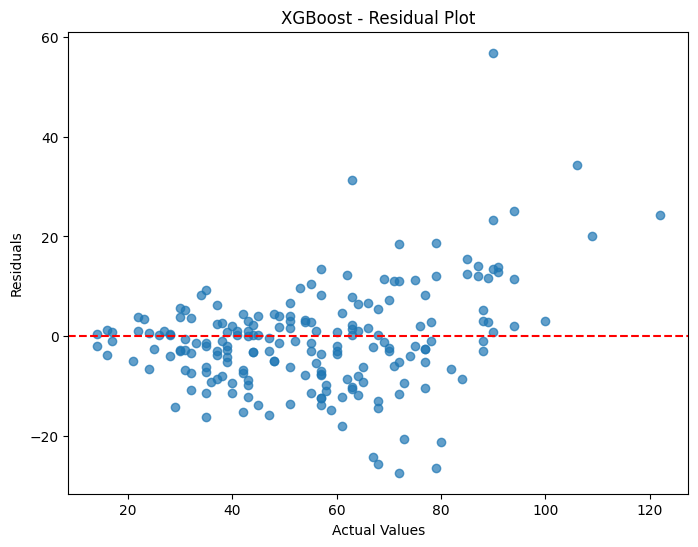

In [88]:
plot_residuals("XGBoost", y_test, y_pred)

Residual Plot (XGBoost):

- Residuals pada plot tersebar acak di sekitar garis 0, yang menunjukkan bahwa model XGBoost tidak memiliki bias sistematik dalam prediksi. Ini adalah tanda bahwa kesalahan model tidak mengikuti pola tertentu.
- Beberapa titik residual terlihat lebih jauh dari garis 0 (terutama di bagian kanan), yang mengindikasikan adanya outliers dengan kesalahan prediksi yang lebih besar.
- Secara keseluruhan, residuals tersebar cukup merata, menandakan bahwa model XGBoost sudah bekerja dengan baik meskipun ada beberapa titik yang perlu dianalisis lebih lanjut.


# Optimasi Model

In [89]:
from sklearn.model_selection import GridSearchCV

In [ ]:
#Optimasi Model (Hyperparameter Tuning menggunakan GridSearchCV untuk XGBoost)
# Hanya melakukan optimasi untuk XGBoost
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)

# Tentukan grid search parameters untuk XGBoost
xgb_param_grid = {
    'n_estimators': [100, 200],
    'learning_rate': [0.01, 0.1],
    'max_depth': [3, 6, 10]
}

grid_search = GridSearchCV(estimator=xgb_model, param_grid=xgb_param_grid, scoring='neg_mean_squared_error', cv=5, verbose=1)
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


In [ ]:
# Tampilkan parameter terbaik dari GridSearchCV
print(f"Best Hyperparameters: {grid_search.best_params_}")
best_xgb_model = grid_search.best_estimator_

# Pilih Model Terbaik

In [ ]:
#Pilih Model Terbaik: Evaluasi dan pemilihan berdasarkan performa
models = {
    'Linear Regression': LinearRegression(),
    'XGBoost': best_xgb_model
}

model_performance = {}

In [ ]:
# Latih dan evaluasi setiap model
for model_name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    # Menyimpan hasil evaluasi
    model_performance[model_name] = {'MSE': mse, 'R2': r2}

    # Visualisasi perbandingan prediksi dan nilai aktual
    plot_predictions(model_name, y_test, y_pred)

    # Visualisasi residuals
    plot_residuals(model_name, y_test, y_pred)

1. Akurasi Model:
XGBoost sedikit lebih baik dalam memprediksi waktu pengantaran dibandingkan Linear Regression, dengan lebih sedikit titik yang menyimpang dari garis ideal dan distribusi residual yang lebih merata.

2. Residuals:
Kedua model menunjukkan adanya beberapa kesalahan prediksi besar, tetapi XGBoost cenderung memberikan hasil yang lebih stabil dan akurat.

In [ ]:
# Menampilkan hasil performa model
print("Model Performance:")
for model_name, performance in model_performance.items():
    print(f"{model_name} - MSE: {performance['MSE']:.4f}, R2: {performance['R2']:.4f}")

# Menentukan model terbaik berdasarkan R2
best_model_name = max(model_performance, key=lambda x: model_performance[x]['R2'])
best_model = models[best_model_name]
print(f"\nModel terbaik adalah {best_model_name} dengan R2 terbaik: {model_performance[best_model_name]['R2']:.4f}")

# Insight dari Hasil Performa Model:

1. Linear Regression:
- MSE = 77.9066: Model Linear Regression memiliki kesalahan prediksi yang lebih rendah, menunjukkan model ini lebih baik dalam memprediksi waktu pengantaran dibandingkan dengan XGBoost.
- R² = 0.8262: Model Linear Regression menjelaskan sekitar 82.62% variasi dalam data, yang menunjukkan bahwa model ini cukup baik dalam memprediksi waktu pengantaran.

2. XGBoost:
- MSE = 89.9202: XGBoost memiliki MSE lebih tinggi, yang menunjukkan model ini kurang efektif dibandingkan dengan Linear Regression dalam meminimalkan kesalahan prediksi.
- R² = 0.7994: R² XGBoost sedikit lebih rendah dibandingkan dengan Linear Regression (79.94% variasi yang dijelaskan), menunjukkan performa model XGBoost yang sedikit lebih buruk dalam memprediksi waktu pengantaran.

3. Model Terbaik:
- Berdasarkan metrik R², Linear Regression dipilih sebagai model terbaik karena memiliki nilai R² lebih tinggi (0.8262) dibandingkan dengan XGBoost (0.7994).
- Model terbaik menunjukkan Linear Regression memiliki performa lebih baik dalam hal akurasi prediksi meskipun XGBoost adalah model yang lebih kompleks.

# Insight Bisnis:

1. Optimalisasi Pengiriman Berdasarkan Jarak:
Jarak adalah faktor utama dalam pengiriman, sehingga perusahaan sebaiknya memprioritaskan pengiriman dengan jarak yang lebih dekat untuk efisiensi waktu.

2. Peningkatan Proses Persiapan:
Mengurangi waktu persiapan bisa menjadi cara langsung untuk meningkatkan efisiensi pengiriman. Fokus pada proses yang mempercepat persiapan makanan bisa mengurangi total waktu pengiriman.

3. Manajemen Rute Berdasarkan Lalu Lintas dan Kendaraan:
- Tingkat lalu lintas memberikan pengaruh yang lebih kecil, namun tetap penting untuk mempertimbangkan kondisi ini dalam perencanaan rute dinamis, terutama di daerah padat lalu lintas.
- Jenis kendaraan mungkin perlu disesuaikan dengan kondisi rute atau cuaca untuk meminimalkan keterlambatan.

# Feature Importance

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, r2_score
import matplotlib.pyplot as plt


In [ ]:
#Fitting the model

model = LinearRegression()
model.fit(X_train, y_train)

In [ ]:
features = X_train.columns
coefficients = model.coef_
plt.figure(figsize=(10, 6))
bars = plt.barh(y=features, width=coefficients, edgecolor="#008031", linewidth=1)

for bar in bars:
    width = bar.get_width()
    plt.text(width + 1, bar.get_y() + bar.get_height()/2, f"{width:.2f}",
             va="center", ha="left")

plt.xlabel("Coefficient value")
plt.title("Linear Regression Model Coefficients", y=1.05)
plt.show()

# Fitur yang Paling Berdampak:

1. Tingkat Lalu Lintas (Traffic Level) memiliki koefisien tertinggi (5.48), yang menunjukkan bahwa tingkat lalu lintas memiliki dampak terbesar terhadap prediksi waktu pengantaran. Semakin tinggi tingkat lalu lintas, semakin lama waktu pengantaran.

2. Jarak (Distance_km) juga memiliki koefisien yang signifikan sebesar 3.00, yang masuk akal karena semakin jauh jarak, semakin lama waktu pengantaran.
Fitur yang Berdampak Moderat:

3. Cuaca (Weather) memiliki koefisien 2.01, menunjukkan bahwa kondisi cuaca juga mempengaruhi waktu pengantaran, meskipun tidak sebesar lalu lintas atau jarak.

4. Waktu Persiapan (Preparation Time) dengan koefisien 0.97 menunjukkan bahwa semakin lama waktu persiapan, semakin lama waktu pengantaran secara keseluruhan.
Fitur dengan Dampak Lebih Rendah:

5. Jenis Kendaraan (Vehicle Type) dengan koefisien 0.73 dan Waktu Hari (Time of Day) dengan koefisien 0.12 memiliki pengaruh yang lebih kecil terhadap waktu pengantaran dibandingkan fitur lainnya. Meskipun begitu, dampak Jenis Kendaraan masih positif.
Dampak Negatif:

6. Pengalaman Kurir (Courier Experience) dengan koefisien -0.70 menunjukkan bahwa pengalaman kurir yang lebih banyak cenderung menghasilkan waktu pengantaran yang lebih cepat. Hal ini masuk akal, karena kurir yang lebih berpengalaman biasanya dapat mengantarkan barang lebih efisien.

# Kesimpulan:
Tingkat Lalu Lintas dan Jarak adalah fitur yang paling berpengaruh untuk memprediksi waktu pengantaran. Sementara itu, Pengalaman Kurir memiliki pengaruh negatif terhadap waktu pengantaran, yang berarti semakin berpengalaman kurir, semakin cepat pengantaran yang dilakukan.

# Deploy Model

In [ ]:
!pip install gradio

In [ ]:
import gradio as gr

In [ ]:
# Fitting the model

model = LinearRegression()
model.fit(X_train, y_train)

In [ ]:
y_pred = model.predict(X_test) #Predictions of the test data

In [ ]:
from sklearn.metrics import accuracy_score, classification_report

y_test_binary = (y_test > 0.5).astype(int)
y_pred_binary = (y_pred > 0.5).astype(int)

accuracy = accuracy_score(y_test_binary, y_pred_binary)
print(f"Accuracy: {accuracy:.2f}")

report = classification_report(y_test_binary, y_pred_binary)
print(f"Classification Report:\n{report}")

In [ ]:
# Prediction function for the gradio

def predict_delivery_time(Distance_km, Weather, Traffic_Level, Time_of_Day, Vehicle_Type, Preparation_Time_min, Courier_Experience_yrs):
    weather_map = {"Clear": 0, "Windy": 1, "Foggy": 2, "Rainy": 3, "Snowy": 4}
    time_of_day_map = {"Morning": 0, "Afternoon": 1, "Evening": 2, "Night": 3}
    traffic_level_map = {"Low": 0, "Medium": 1, "High": 2}
    vehicle_type_map = {"Scooter": 0, "Bike": 1, "Car": 2}
    try:
        # Converting the dropdown inputs
        weather_encoded = weather_map[Weather]
        traffic_encoded = traffic_level_map[Traffic_Level]
        time_encoded = time_of_day_map[Time_of_Day]
        vehicle_encoded = vehicle_type_map[Vehicle_Type]

        # The data chosen in the gradio will be placed here
        input_data = pd.DataFrame({
            "Distance_km": [Distance_km],
            "Weather": [weather_encoded],
            "Traffic_Level": [traffic_encoded],
            "Time_of_Day": [time_encoded],
            "Vehicle_Type": [vehicle_encoded],
            "Preparation_Time_min": [Preparation_Time_min],
            "Courier_Experience_yrs": [Courier_Experience_yrs]
        })
        # Predicting the delivery time
        prediction = model.predict(input_data)[0]
        return round(prediction, 2)
    except KeyError as e:
        return f"Error: Invalid input value - {e}"

In [ ]:
# The dropdowns and interactions of the gradio interface app

iface = gr.Interface(
    fn=predict_delivery_time,
    inputs=[
        gr.Number(label="Distance (km)"),
        gr.Dropdown(["Clear", "Windy", "Foggy", "Rainy", "Snowy"], label="Weather"),
        gr.Dropdown(["Low", "Medium", "High"], label="Traffic Level"),
        gr.Dropdown(["Morning", "Afternoon", "Evening", "Night"], label="Time of Day"),
        gr.Dropdown(["Scooter", "Bike", "Car"], label="Vehicle Type"),
        gr.Number(label="Preparation Time (minutes)"),
        gr.Number(label="Courier Experience (years)")
    ],
    outputs=gr.Number(label="Predicted Delivery Time (minutes)"),
    title="Delivery Time Prediction",
    description="Enter the details to predict the estimated delivery time."
)

# Launching the gradio app
iface.launch()